In [13]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import os
import pickle
import random 
import operator
import math
import numpy as np
import os
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
from scipy.fft import fft, ifft
from collections import Counter
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, confusion_matrix

pd.options.display.max_columns = 1000


# make window wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
def read_data(features,timbre_features,filename,file_timbre):
    pdread = pd.read_csv(filename)
    dataframe = pd.DataFrame({})
    pdread_timbre = pd.read_csv(file_timbre)
    
    for l in range(len(features)):
        data_feature = np.array(pdread[pdread.index==l])
        data_feature[0][1:-1]
        dataframe[features[l]]=data_feature[0][1:-1]

    for l in range(len(timbre_features)):
        data_feature = np.array(pdread_timbre[pdread_timbre.index==l])
        dataframe[timbre_features[l]]=data_feature[0][1:-1]
        
    
    mads_data = pd.read_csv('syncopation_data.csv')
    new_data = pd.DataFrame({})
    for i in folders:
        new_data = pd.concat([new_data, mads_data[mads_data['genre']==i]])
        columns_new_data = new_data.columns[2:21]
    
    for l in columns_new_data:
        dataframe[columns_new_data] = new_data[columns_new_data]
    
    mads_data2 = pd.read_csv('rythmic_data.csv')
    new_data2 = pd.DataFrame({})
    for i in folders:
        new_data2 = pd.concat([new_data2, mads_data2[mads_data2['genre']==i]])
        columns_new_data2 = new_data2.columns[2:8]


    for l in columns_new_data2:
        dataframe[columns_new_data2] = new_data2[columns_new_data2]
    

    return(dataframe,columns_new_data,columns_new_data2)

In [3]:
# load all data
features = ['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std','fourier_mean','chroma_cens', 'class']
timbre_features = ['hardness','depth','brightness','roughness','warmth','sharpness','boominess','reverb']
folders = ['pop','jazz','blues','classical','hiphop','metal','rock','reggae','disco','country']

dataframe, columns_new_data,columns_new_data2 = read_data(features,timbre_features,"other_features.csv",'timbre_secure.csv')
dataframe.head(5)

,zerocrossing,spectralrolloff,chromagramstd,chromagrammean,fourier_std,fourier_mean,chroma_cens,class,hardness,depth,brightness,roughness,warmth,sharpness,boominess,reverb,overlap0,overlap1,overlap1Early,overlap1Late,overlap2,overlap2Early,overlap2Late,overlap3,overlap3Early,overlap3Late,overlap4,overlap4Early,overlap4Late,overlap5,overlap5Early,overlap5Late,overlap6,overlap6Early,overlap6Late,tempo,tempoHarmonic,tempoPercussive,onBeat,onBeatHarmonic,onBeatPercussive
0,490.0,7916.478436,0.286046,61.724392,155.002121,0.389286,0.301558,0.0,62.184903,64.482713,64.901826,54.344498,47.473584,58.247913,31.572225,1.0,1.753658,0.210424,0.013987,0.620453,0.040014,0.012410,0.176721,0.054571,0.025400,0.455789,0.047221,0.009912,0.108415,0.014026,0.005603,0.034720,0.011328,0.003119,0.020560,123.046875,123.046875,123.046875,0.219255,0.173677,0.175861
1,704.0,8049.560283,0.306736,98.570839,213.782852,0.413187,0.312815,0.0,63.719431,61.089713,68.271124,59.738090,45.438443,60.019366,32.193873,0.0,2.785280,0.394667,0.231321,0.139635,0.916249,0.278263,0.168726,1.532961,0.236100,0.073923,0.009115,0.002881,0.018700,0.430154,0.087305,0.016993,0.244307,0.056372,0.050570,67.999589,67.999589,67.999589,0.301049,0.216952,0.254102
2,913.0,7392.282121,0.306183,71.167252,173.006790,0.417412,0.305931,0.0,61.194341,60.537756,64.919842,59.427448,46.784449,56.371713,34.493369,1.0,2.697888,0.132710,0.703458,0.026851,0.028507,0.455132,0.068784,0.018781,0.517178,0.008158,0.049385,0.087481,0.014999,0.036461,0.023254,0.011404,0.014722,0.022702,0.018540,161.499023,161.499023,161.499023,0.186501,0.139141,0.153761
3,849.0,3639.036502,0.293715,44.226902,101.596466,0.407685,0.284466,0.0,59.058285,58.243250,63.018400,55.438606,48.175596,48.531268,31.120960,1.0,2.141774,0.234815,0.401124,0.182243,0.500865,0.377981,0.042896,0.631104,0.466492,0.018109,0.059323,0.058655,0.003395,0.137122,0.089858,0.013440,0.140773,0.112868,0.057044,63.024009,172.265625,63.024009,0.413590,0.136438,0.322781
4,697.0,5958.993877,0.258193,89.199371,152.478058,0.384264,0.289209,0.0,62.573535,53.332775,65.535807,61.639147,44.527119,54.425945,27.943247,1.0,3.026272,0.276725,0.588319,0.049129,0.145096,0.293845,0.017441,0.138670,0.524937,0.071714,0.080301,0.139576,0.015173,0.038622,0.050418,0.016668,0.034647,0.039175,0.013946,135.999178,135.999178,135.999178,0.210587,0.190118,0.165812


In [4]:
# choose a certain number of genres
dataframe_cut = pd.DataFrame({})
chosen_genres = [0,1,2,3,4,5,6,7,8,9]
#[3,5,8]

for i in chosen_genres:
    dataframe_cut = dataframe_cut.append(dataframe[dataframe['class']==i])

dataframe_cut['class_num'] = pd.factorize(dataframe_cut['class'])[0]

In [5]:
# choose which variables to look at
df_1=[]
train_features = np.concatenate([['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std',
                  'fourier_mean','chroma_cens','hardness','depth','brightness','roughness','warmth',
                  'sharpness','boominess','reverb'],columns_new_data, columns_new_data2])


df_1=dataframe_cut[train_features]

#Scaling using the Standard Scaler
sc_1=StandardScaler()
sc_1.fit(df_1)
X_1=pd.DataFrame(sc_1.fit_transform(df_1))#, columns=train_features)

Y_1=dataframe_cut['class_num']
X_1.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,-0.851135,2.116395,0.343941,0.461131,1.046465,0.129964,0.592023,0.742421,1.794114,0.257451,-0.464511,0.291734,1.096321,0.360464,0.410391,-0.162705,0.234719,-0.407170,1.873289,-0.515846,-0.448877,-0.107067,-0.171968,-0.216355,2.017063,-0.378348,-0.359473,-0.002714,-0.156590,-0.414052,0.299869,-0.421991,-0.464429,-0.201673,0.125427,0.116489,0.143358,-0.315976,-0.055605,-0.541016
1,-0.425409,2.199051,0.592302,1.802687,2.222829,0.422737,1.426974,1.038576,1.238953,0.938796,0.413594,-0.175984,1.371461,0.489101,-2.436699,0.308747,1.041881,0.452544,0.048210,0.737232,0.198196,-0.123627,5.473112,1.124556,0.054431,-0.454601,-0.386901,-0.342538,2.593548,1.519386,-0.139794,1.058754,0.353669,0.191381,-1.822188,-1.917865,-2.024209,0.797973,0.339083,1.259922
2,-0.009630,1.790823,0.585668,0.804939,1.406788,0.474489,0.916390,0.551248,1.148642,0.261094,0.363020,0.133357,0.804913,0.964934,0.410391,0.268809,-0.105742,2.320190,-0.379893,-0.532303,0.628687,-0.330665,-0.308629,2.913360,-0.283572,-0.374016,-0.056873,-0.356558,-0.008319,0.003643,-0.278409,-0.400421,-0.163582,-0.228123,1.485893,1.537545,1.657467,-0.762046,-0.370593,-1.049725
3,-0.136950,-0.540270,0.436004,-0.175943,-0.022329,0.355342,-0.675808,0.139001,0.773216,-0.123419,-0.286385,0.453072,-0.412852,0.267085,0.410391,0.014664,0.341575,1.124241,0.209941,0.143203,0.440907,-0.384293,2.029463,2.590792,-0.232426,-0.354130,-0.169323,-0.400512,0.656940,1.579804,-0.227900,0.400722,1.221588,0.276162,-1.998227,1.935441,-2.220130,2.330655,-0.395246,2.840772
4,-0.439335,0.900626,0.009600,1.461478,0.995952,0.068456,-0.324025,0.817424,-0.030234,0.385656,0.723096,-0.385425,0.502699,-0.390476,0.410391,0.418881,0.525180,1.864733,-0.295331,-0.365573,0.236122,-0.437026,0.149154,2.962742,0.043080,-0.312151,0.146353,-0.355900,0.005967,0.646471,-0.147834,-0.273785,0.089478,-0.288297,0.583689,0.595161,0.653373,-0.434023,0.094346,-0.772328


In [6]:
# set up LGBM classifier
params={}
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=10
params['num_class']=10
params['num_leaves']=14
params['force_col_wise']=True
params['verbose'] = -1
params['learning_rate']=0.1
epochs = 500
#len(os.listdir()) #no.of unique values in the target class not inclusive of the end value
#training the model
score_array=[]

evals_result={}

In [38]:
# run LGBM classifier
test = False

testsize = 0.2

if test==True:
    for param in range(50):
        #params['max_depth']=param+1
        X_train,X_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=testsize,random_state=param)
        d_train=lgb.Dataset(X_train, label=y_train)

        clf=lgb.train(params,d_train,param*100+1)

        y_pred_1=clf.predict(X_test)

        y_pred_m = [np.argmax(line) for line in y_pred_1]

        score = precision_score(y_pred_m,y_test,average=None).mean()
        score_array.append(score)
        plt.plot(score_array)
else:
    X_train,X_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=0.2,random_state=42)
    d_train=lgb.Dataset(X_train, label=y_train)
    
    clf=lgb.train(params,d_train ,epochs)

    y_pred_1=clf.predict(X_test)

    y_pred_m = [np.argmax(line) for line in y_pred_1]

    score = precision_score(y_pred_m,y_test,average=None).mean()
    

print(score)
print(np.array(y_test)-np.array(y_pred_m))

0.7229987401659229
[ 0  0  1  0 -2  0  4 -1 -4 -1  0  0  0  0  0  0  0  0  0  0  5  0  0  1
  0  0 -1  0  8  0  0  0  0  0  0  1  0  0  6  0 -1  0  0  0  0  0 -5  0
  0  0 -2  0  3  0  0  0 -8 -4  0  0  0  0  0  0  0  0  0  5  0  0  0  0
  0  0  0  0  0  0  3  0  0  0  0  1 -3 -1  0  0  0  0  0  0  0  0 -1  0
 -9  0  0  0  0  0  0  0 -1  3  0  0  0 -3  0  0 -8  0  0  0  0  0  3  0
  0  0  0  0 -1  0  0  0  0  1  0  3  0  0  0  3  0 -6  0  0  3 -7  0  0
  0  0 -4  0 -4  7  0  0  0  3  1  0 -3  0  0  0  0 -1  0  0  0  1 -1  0
  0  0  0  0  0  8 -2  3  9  0  4 -3  0  0  0  0  0  0  0  0  0  0  9  0
  0  0 -5  0  0  0 -3 -5]


In [8]:
#Test different genres accuracy

y_pred_m = np.array(y_pred_m)
y_test = np.array(y_test)

for jj in range(len(chosen_genres)):
    sum=0
    correct=0
    for kk in range(len(y_pred_m)):
        if y_test[kk] == jj:
            sum=sum+1
            if y_pred_m[kk] == jj:
                correct = correct +1
                
    print(folders[chosen_genres[jj]],correct/sum)

pop 0.8095238095238095
jazz 0.9166666666666666
blues 0.75
classical 0.8636363636363636
hiphop 0.7333333333333333
metal 0.7142857142857143
rock 0.5882352941176471
reggae 0.45
disco 0.7727272727272727
country 0.631578947368421


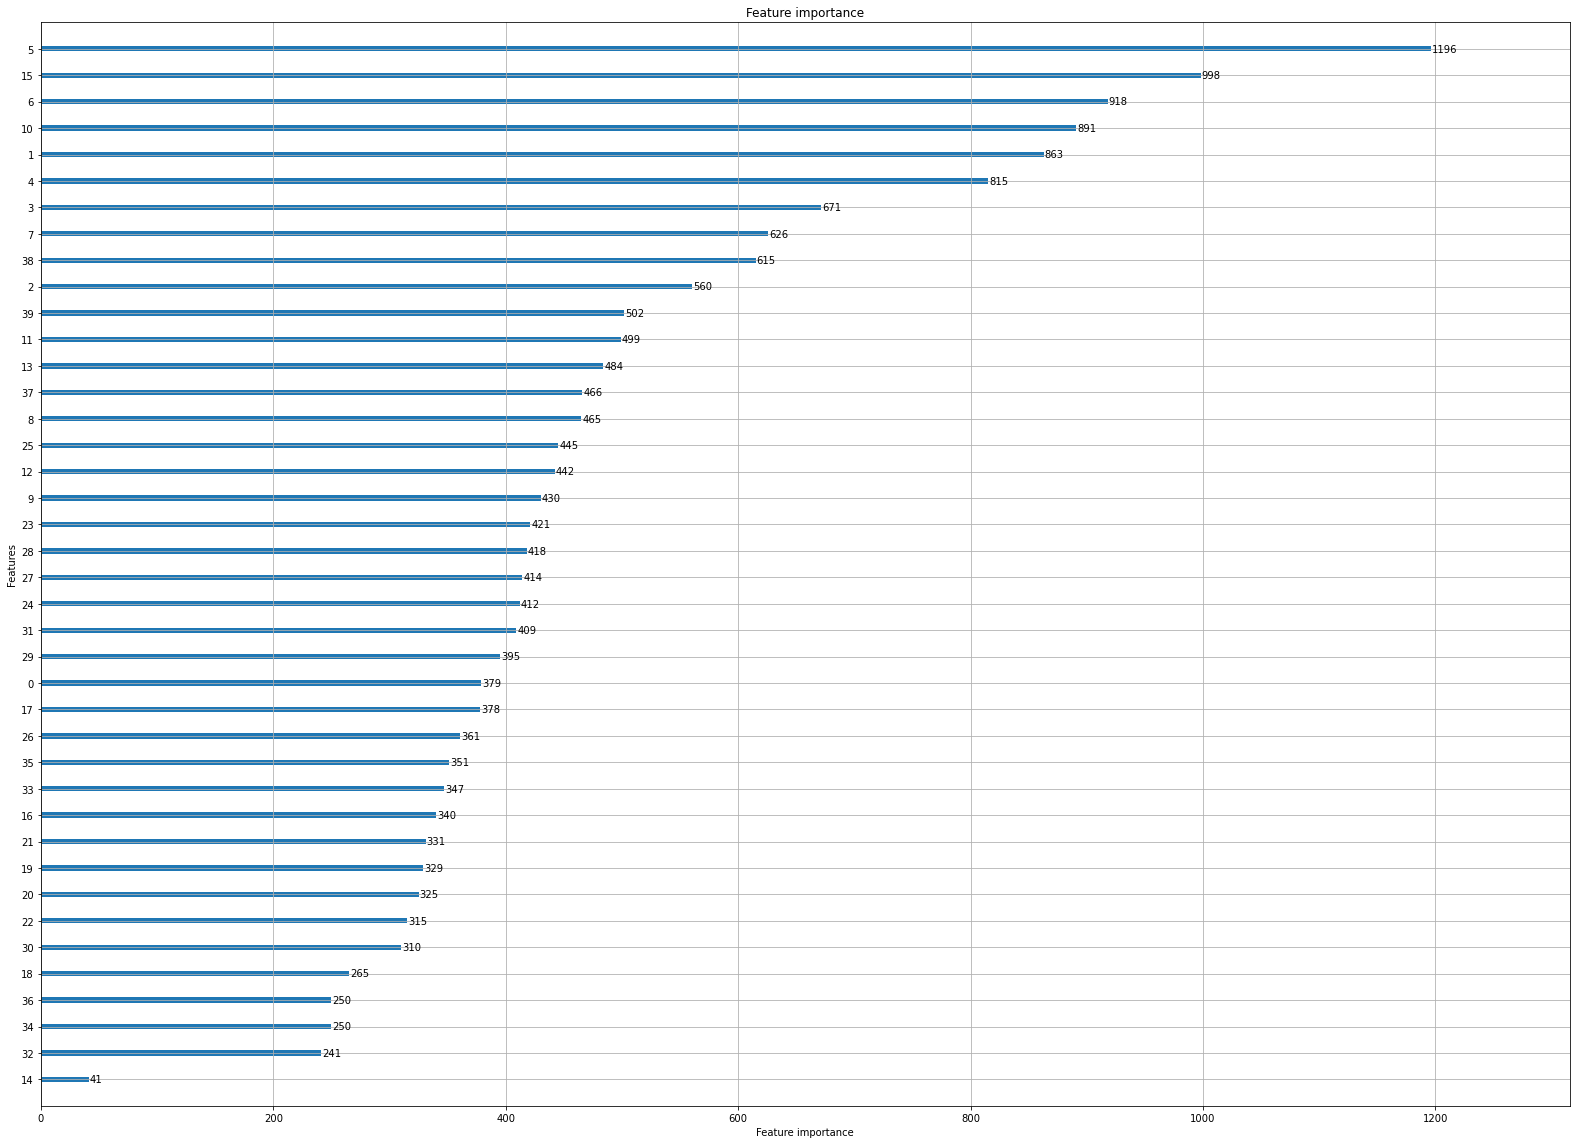

In [9]:
# Feature importance

hf=plt.figure(figsize=(22,16))
hf.clf()
ax=hf.add_subplot(111)
axes = lgb.plot_importance(clf,ax=ax)

# labels = [item.get_text() for item in axes.get_yticklabels()]

# feature_imp_labels = []

# for h in range(len(labels)):
#     index = int(labels[h])
#     feature_imp_labels.append(train_features[index])
    
# axes.set_yticklabels(feature_imp_labels)

plt.tight_layout()

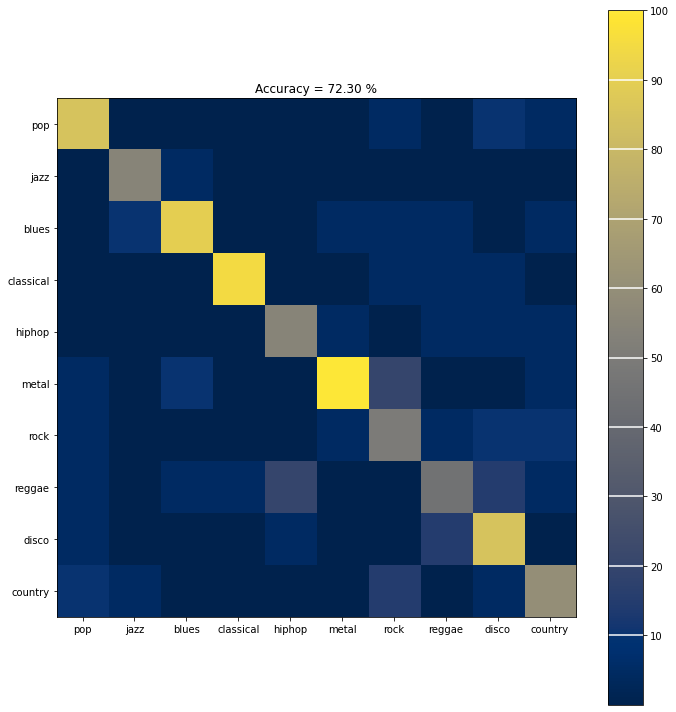

In [65]:

# score=precision_score(y_pred_lgb_probs_highest,y_val,average=None).mean()
cmat = confusion_matrix(y_test,y_pred_m )
plt.figure(figsize=(10,10))
plt.imshow(cmat/(testsize), cmap='cividis')

cbticks=[10,20,30,40,50,60,70,80,90,100]

ax=plt.gca()
ax.set_xticks(np.array(chosen_genres))
ax.set_xticklabels([folders[genre_index] for genre_index in chosen_genres])

ax.set_yticks(np.array(chosen_genres))
ax.set_yticklabels([folders[genre_index] for genre_index in chosen_genres])
cb=plt.colorbar(ticks=cbticks)
cb.ax.plot([0,100],[cbticks, cbticks],'w')
plt.title('Accuracy = {:.2f} %'.format(100*score))
plt.tight_layout()

SyntaxError: invalid syntax (<ipython-input-45-46ff9228c756>, line 1)